In [1]:
import requests
import json
import re
import datetime
import pandas as pd
from collections import Counter

API_KEY = "[CENSORED]"  # see readme
ISO_REGEX = re.compile(r"PT((\d\d?)H)?((\d\d?)M)?((\d\d?)S)?")  # parse a time format like PD1H2M3S to capture 1, 2, 3
DATE_ID_REGEX = re.compile(r".{26}(.+?)</a><br>(\d.+?)</div>.+?v=(.{11})\">(.+?)</a>")  # parse a line capturing channel, date_string, video_id, title
DATE_FORMAT = '%d %b %Y, %H:%M:%S CEST'  # for parsing dates
N = 50  # max urls per request, as api says

# helper methods
def int_(x):  # convert none to 0 and strings to int
    return int(x) if x else 0

def parse(iso_time):
    # ignore videos with time > 1d
    if re.match(ISO_REGEX, iso_time):
        _, h, _, m, _, s = re.match(ISO_REGEX, iso_time).groups()
        h, m, s = int_(h), int_(m), int_(s)
        if h < 3:
            return h * 3600 + m * 60 + s
    return 0

data = {}
# load urls from file (you have to provide this)
with open(r"YouTube and YouTube Music/history/watch-history.html", "rb") as f:
    fc = f.read().decode("latin1")
    for line in fc.split("<a href=\"https://www.youtube.com/channel/"):
        # print(line)
        if re.match(DATE_ID_REGEX, line):
            channel, date_string, video_id, title = re.match(DATE_ID_REGEX, line).groups()
            data[video_id] = {"date": datetime.datetime.strptime(date_string, DATE_FORMAT), "channel": channel, "title": title}

In [2]:
# fetch data form API in 50-steps
urls = list(data)
for i in range(len(urls) // N):
    VIDEO_KEY = ",".join(urls[i*N:(i+1)*N])
    url = f"https://www.googleapis.com/youtube/v3/videos?id={VIDEO_KEY}&part=contentDetails&key={API_KEY}"
    resp = json.loads(requests.get(url).text)
    for item in resp["items"]:
        iid = item["id"]
        data[iid].update(item["contentDetails"])
        data[iid]["duration"] = parse(item["contentDetails"]["duration"])
        del data[iid]["contentRating"]

In [3]:
df = pd.DataFrame.from_dict(data, orient="index")
df.duration /= 3600
df.to_csv("df.csv")

print("Invalid videos", df["duration"].isna().sum())
print(f"Total watch time in h {df.duration.sum():.2f}")
print()
print("Most watched videos")
print(df.groupby(df.channel).sum().sort_values("duration", ascending=False).head(30))


Invalid videos 264
Total watch time in h 4468.16

Most watched videos
                        duration
channel                         
The Escapist          123.386389
CollegeHumor          113.467500
Linus Tech Tips        87.872778
LeFloid                71.727500
Wisecrack              63.458333
SPACE FROGS            59.133889
Siraj Raval            58.385833
Extra Credits          56.965556
NEO MAGAZIN ROYALE     56.295833
PewDiePie              54.728611
The Game Theorists     54.498889
LiveOverflow           47.904167
Two Minute Papers      45.335556
ExplosmEntertainment   44.537222
TheXclusiveAce         43.273056
LastWeekTonight        41.076944
The Film Theorists     39.463333
Screen Rant            39.413056
media.ccc.de           36.115833
Mrwhosetheboss         33.565000
Dave Lee               32.925000
JoergSprave            31.006944
STRG_F                 30.952500
Vsauce                 27.789167
Marques Brownlee       25.814167
Drift0r                25.287222
Hutts 

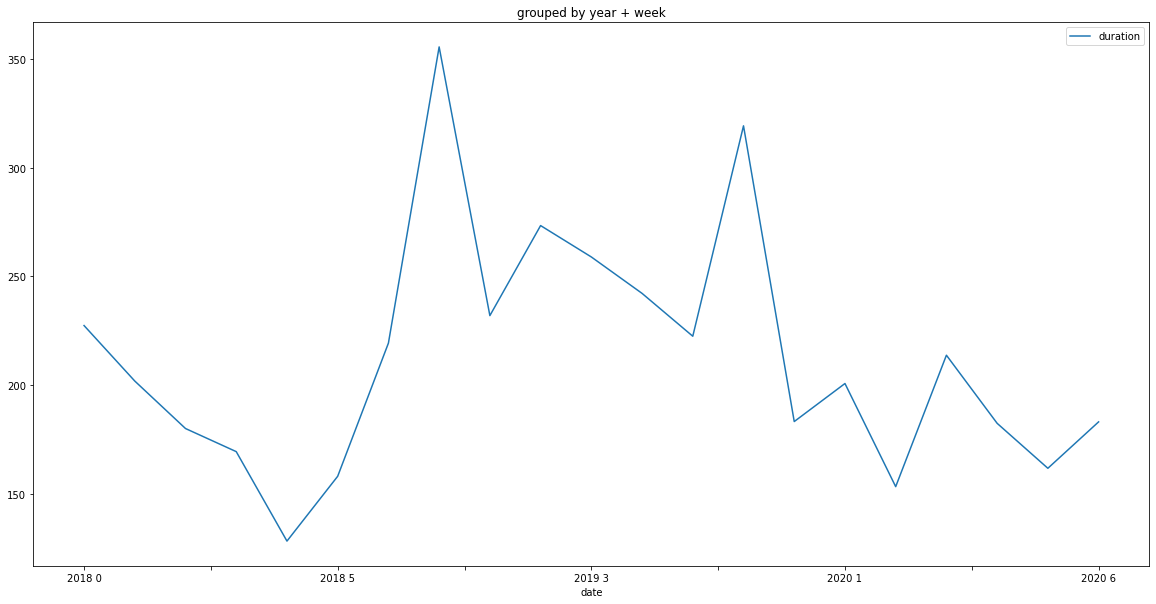

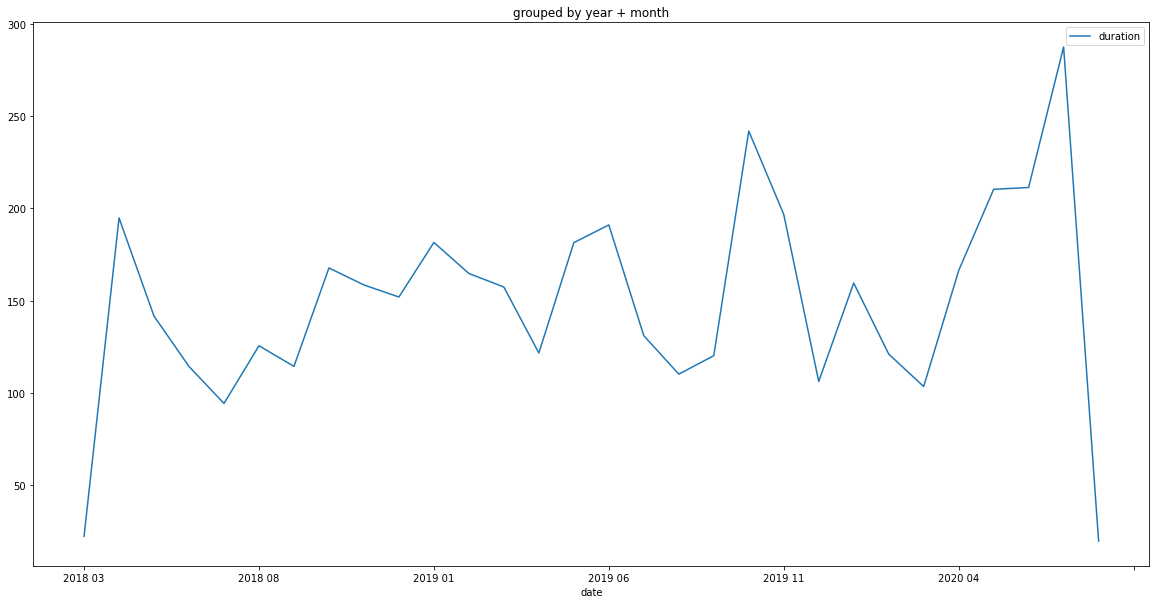

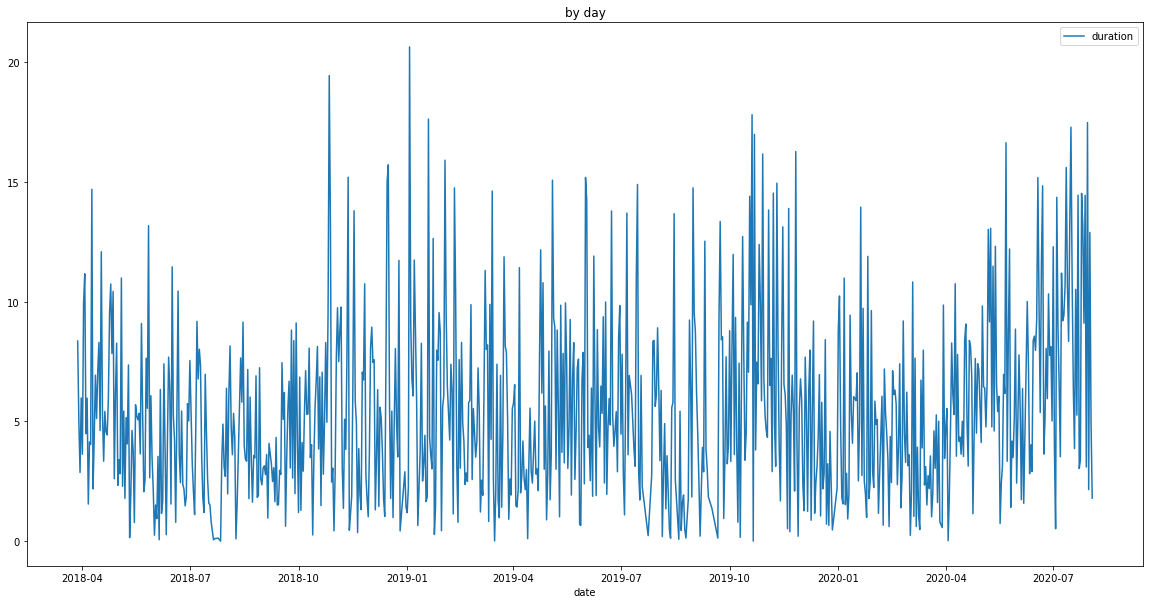

In [4]:
# visualization
date = pd.to_datetime(df["date"])  # helper accessor
df.groupby(date.dt.strftime("%Y %w")).sum().plot(title="grouped by year + week", figsize=(20, 10))
df.groupby(date.dt.strftime("%Y %m")).sum().plot(title="grouped by year + month", figsize=(20, 10))
df.groupby(date.dt.date).sum().plot(title="by day", figsize=(20, 10))

In [5]:
li = df.title.to_list()
li = "".join(li).lower().split(" ")
print("most common words in title + count")
Counter(li).most_common(50)

most common words in title + count


[('-', 5922),
 ('the', 3279),
 ('|', 3149),
 ('of', 1916),
 ('to', 1881),
 ('in', 1780),
 ('a', 1590),
 ('is', 1192),
 ('&amp;', 1097),
 ('and', 1075),
 ('with', 853),
 ('for', 696),
 ('you', 665),
 ('on', 503),
 ('', 484),
 ('mit', 463),
 ('die', 420),
 ('game', 405),
 ('your', 378),
 ('from', 351),
 ('best', 349),
 ('â\x80\x93', 335),
 ('review', 329),
 ('der', 320),
 ('theory:', 315),
 ('how', 310),
 ('3', 310),
 ('vs', 304),
 ('extra', 299),
 ('i', 297),
 ('are', 291),
 ('2', 283),
 ('new', 282),
 ('part', 272),
 ('this', 268),
 ('modern', 262),
 ('neo', 259),
 ('magazin', 258),
 ('an', 256),
 ('jan', 251),
 ('royale', 250),
 ('my', 235),
 ('that', 232),
 ('it', 227),
 ('und', 222),
 ('bã¶hmermann', 216),
 ('warfare', 214),
 ('10', 213),
 ('pro', 208),
 ('episode', 208)]